In [1]:
from datasets import load_dataset
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from scipy.stats import hmean, norm
from nltk import word_tokenize
from collections import Counter
from scipy.optimize import minimize_scalar
from scipy.optimize import minimize
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import numpy as np
from statistics import harmonic_mean

In [10]:
#data= load_dataset("imdb", split= "test")
#data= load_dataset("oscar", "unshuffled_deduplicated_en", split = "train", streaming= True)
#data= load_dataset("poem_sentiment","plain_text", split = "test")
data = load_dataset("bible_para", lang1="fr", lang2="ru",split="train")
#data_head = data.take(10)

Using custom data configuration fr-ru-lang1=fr,lang2=ru
Reusing dataset bible_para (/home/sasha/.cache/huggingface/datasets/bible_para/fr-ru-lang1=fr,lang2=ru/0.0.0/b6cc20bcbfb0299beeba1dcc80a8420b975938ca0eef75b3ed30b50df7d950b1)


In [ ]:
#For streaming data
data_head = data.take(10000)
datadf= pd.DataFrame(data_head)

In [11]:
#for non-streaming data
datadf = pd.json_normalize(data)

#### Looking at the top rows

In [12]:
datadf.head()

,id,translation.fr,translation.ru
0,0,"Au commencement, Dieu créa les cieux et la terre.",В начале сотворил Бог небо и землю.
1,1,La terre était informe et vide: il y avait des...,"Земля же была безвидна и пуста, и тьма над без..."
2,2,Dieu dit: Que la lumière soit! Et la lumière fut.,И сказал Бог: да будет свет. И сталсвет.
3,3,Dieu vit que la lumière était bonne; et Dieu s...,"И увидел Бог свет, что он хорош, и отделил Бог..."
4,4,"Dieu appela la lumière jour, et il appela les ...","И назвал Бог свет днем, а тьму ночью. И был ве..."


#### Getting more information

In [13]:
datadf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31102 entries, 0 to 31101
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              31102 non-null  object
 1   translation.fr  31102 non-null  object
 2   translation.ru  31102 non-null  object
dtypes: object(3)
memory usage: 729.1+ KB


#### Checking for missing values

In [14]:
datadf[datadf.isnull().any(axis=1)].head()

,id,translation.fr,translation.ru


In [15]:
np.sum(datadf.isnull().any(axis=1))

0

#### Count vocab size + frequencies

In [22]:
def count_vocab_frequencies(dataframe, col):
    """
    Based on an input pandas DataFrame with a 'text' column, 
    this function will count the occurrences of ALL words 
    (no stop word removal) and will return another DataFrame
    with the rows corresponding to the different vocabulary words
    and the column to the total count of that word.
    """
    cvec = CountVectorizer(token_pattern=u"(?u)\\b\\w+\\b")
    #needed to modify the minimum token length : https://stackoverflow.com/questions/33260505/countvectorizer-ignoring-i
    cvec.fit(dataframe[col])
    document_matrix = cvec.transform(dataframe[col])
    batches = np.linspace(0,dataframe.shape[0],100).astype(int)
    i=0
    tf = []
    while i < len(batches)-1:
        batch_result = np.sum(document_matrix[batches[i]:batches[i+1]].toarray(),axis=0)
        tf.append(batch_result)
        i += 1
    term_freq_df = pd.DataFrame([np.sum(tf,axis=0)],columns=cvec.get_feature_names()).transpose()
    term_freq_df.columns=['total']
    return(term_freq_df)

In [23]:
term_df= count_vocab_frequencies(datadf,'translation.fr')

#### Zipf's law plot

In [25]:
def Zipf_plot(dataframe):
    """
    This function plots the correspondence of the distribution of terms
    generated by count_vocab_frequencies with the projected Zipf's law
    distribution.
    s is the value of the exponent characterizing the distribution, currently at 1.
    # TODO : see if changing this makes the distribution fit better -- 
    e.g. When Zipf's law is checked for cities, a better fit has been found with exponent s = 1.07
    """
    y_pos = np.arange(500)
    plt.figure(figsize=(10,8))
    s = 1
    expected_zipf = [dataframe.sort_values(by='total', ascending=False)['total'][0]/(i+1)**s for i in y_pos]
    plt.bar(y_pos, dataframe.sort_values(by='total', ascending=False)['total'][:500], align='center', alpha=0.5)
    plt.plot(y_pos, expected_zipf, color='r', linestyle='--',linewidth=2,alpha=0.5)
    plt.ylabel('Frequency')
    plt.title("Top 500 tokens in the dataset, with Zipf's law in dotted red")

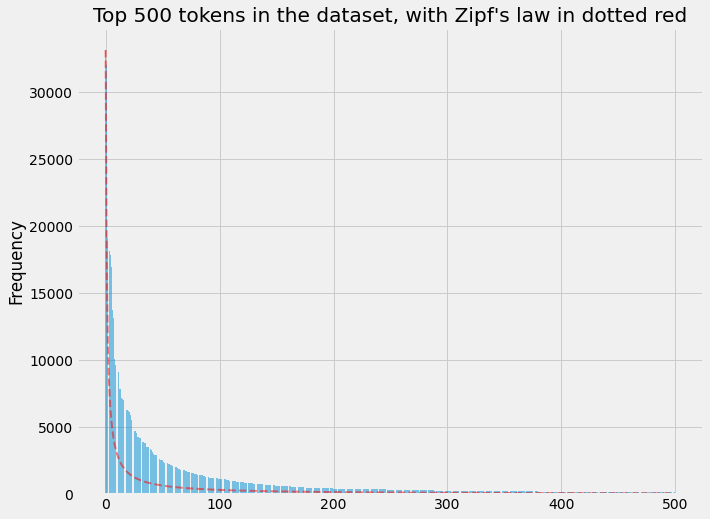

In [26]:
Zipf_plot(term_df)

### Checking which words do not respect Zipf's law

In [27]:
def Zipf_check_words(dataframe, num_words):
    """
    Checks the Zipf's law of the top [num_words] most frequent words in dataframe.
    Returns a dataframe with 3 columns:
    total = the raw number of counts 
    zipf = the projected counts according to Zipf
    difference = the *percentage* difference between the two
    """
    s = 1
    terms = pd.DataFrame(dataframe.sort_values(by='total', ascending=False)['total'][:num_words])
    expected_zipf=[dataframe.sort_values(by='total', ascending=False)['total'][0]/(i+1)**s for i in np.arange(num_words)]
    terms['zipf'] = [int(z) for z in expected_zipf]
    terms['difference'] = terms.apply(lambda x: ((x['total']- x['zipf'])/x['zipf']* 100), axis=1)
    return(terms)

In [28]:
zipf_df= Zipf_check_words(term_df,500)

In [29]:
zipf_df.loc[(zipf_df['difference'] >=100)].head(10)

,total,zipf,difference
l,18140,8274,119.240996
le,17817,6619,169.179634
les,16909,5516,206.544598
à,13718,4728,190.143824
il,13119,4137,217.113851
qui,10108,3677,174.898015
des,9617,3309,190.631611
d,9491,3008,215.525266
que,9115,2758,230.493111
est,7823,2546,207.266300


### Checking open versus closed class words

In [ ]:
#Creating the closed word list from the txt file
wordlist=open('resources/closed_EN.txt', 'r').readlines()
closedlist=[]
for l in wordlist:
    closedlist= closedlist + (l.split())
print("There are: "+ str(len(closedlist)) + " closed-class words in English.")

In [ ]:
def check_closed_class(dataframe, threshold):
    '''
    Based on a dataframe and a threshold, checks how many closed-class 
    words are above the threshold, and returns the dataframe sorted by 
    difference.
    '''
    closedclass= dataframe[dataframe.index.isin(closedlist)]
    closedclassthreshold= closedclass.loc[(closedclass['difference'] >=threshold)]
    print("There are: "+ str(closedclassthreshold.shape[0])+ " closed class words that are above the %s threshold" %(threshold))
    return(closedclassthreshold.sort_values(by='difference', ascending=False))

In [ ]:
check_closed_class(zipf_df,100)

In [ ]:
def check_open_class(dataframe, threshold):
    closedclass= dataframe[dataframe.index.isin(closedlist)]
    openclass= dataframe[~dataframe.index.isin(closedlist)]
    openclassthreshold= openclass.loc[(openclass['difference'] >=threshold)]
    print("There are: "+ str(openclassthreshold.shape[0])+ " closed class words that are above the %s threshold" %(threshold))
    return(openclassthreshold.sort_values(by='difference', ascending=False))

In [ ]:
check_open_class(zipf_df,100)